# SPICEnet: Classification of images of electrical components

*Kristóf Kónya, Jakob Tschavoll*

## Setup

In [26]:
# file related
import os
from os.path import join
import shutil
import json

# image manipulation
from PIL import Image, ImageChops, ImageDraw, ImageFont

# machine learning
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.models import Model, Sequential
from keras.layers import Dense, concatenate
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
import tensorflow as tf
from sklearn.model_selection import train_test_split

# utils
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import random
import pandas as pd

print(f"TF version {tf.__version__}")

TF version 2.11.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if(gpus):
    try:
        for gpu in gpus:            
            tf.config.experimental.set_memory_growth(gpu,True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
gpus

2024-01-21 21:42:02.648969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-21 21:42:02.723130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-21 21:42:02.723720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-21 21:42:02.738282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

1 Physical GPUs, 1 Logical GPUs


2024-01-21 21:42:02.739559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-21 21:42:02.739840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-21 21:42:02.740025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-21 21:42:05.708962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-21 21:42:05.709394: I tensorflow/compiler/xla/stream_executo

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data

### SPICEnet parameters
Data generation and training parameters are all accessible through the below listed dictionary `SPICENET_PARAMS`. The keys are used like this:

- `src_path`: path to the base images relative to the project's root data_dir. Only few are needed, the rest will be created from the source image's augmentations.
- `dataset_path`: path to the dataset relative to the project's root data_dir. This folder **does not need to exist yet**, but you can decide how it is named.
- `resize`: amount of pixels to which input images will be resized (height and width are the same)
- `offset_x`: distance and iterations with which the images will be shifted around for data augmentation. A python `range()` object is expected here. For example, a given `range(-150, 150, 30)` will offset a source image as many times as 30 pixels will fit into a range of 150 to the left and 150 to the right, meaning a total of 300 pixels. Since each step is 30 pixels, this range will produce 10 new images.
- `offset_y`: same as `offset_x` but vertical.
- `rotation`: rotational equivalent of `offset_x/y`. A given `range(0, 180, 2)` will rotate the image from 0 to 180 degrees in 2 degree steps, equating a total of 90 new images.
- `zoom`: scaling equivalent of `offset_x/y`. A given `range(100, 300, 20)` will zoom into the image from 100% to 300% in 20% steps creating a total of 10 new images.
- `letter_noise_n`: amount of artificially added letters for classes "Corner", "Junction" and "Cross" for network robustness.
- `contrast_tresh`: `uint8_t` black and white pixel scaling at which point a pixel will be either shifted to 255 (black) or 0 (white).
- `train_test_ratio`: ratio between the sizes of the train and test data splits, e.g. 0.2 (20%) means that 20% of the whole dataset are used for testing and 80% for training.
- `only_train_test_split`: If this is set to `True`, the unsplit dataset will be temporary and removed after the splitting process is done. What will remain is only the train-test split and the source images.
- `batches`: amount of batches for the all sets
- `epochs`: number of training epochs (a low number is recommended, since the base model is already pretty competent (vgg16)).
- `class_list`: python `list` with readable names of classes. In the dataset, their **intuitive** (not syntactical, e.g. first index is `1`, not `0`) indexes are used instead, e.g. `1` is `"Resistor"`.

In [3]:
SPICENET_PARAMS = dict({
    "src_path": "img_src",
    "dataset_path": "dataset",
    "resize": 224,
    "offset_x": range(-30, 30, 3),
    "offset_y": range(-30, 30, 3),
    "rotation": range(0, 360, 90),
    "zoom": range(100, 105, 1),
    "letter_noise_n": 1,
    "contrast_thresh": 170,
    "train_test_ratio": 0.2,
    "only_train_test_split": True,
    "batches": 20,
    "epochs": 2,
    "class_list": ["Resistor",
                   "Capacitor",
                   "Inductor",
                   "Diode",
                   "Corner",
                   "Junction",
                   "Cross",
                   "GND"]
})

with open("CLASSLIST.json", 'w') as f:
    json.dump(dict({"class_list": SPICENET_PARAMS["class_list"]}), f, indent=4)

### Data generation

In [11]:
def data_offset_image(img: Image, xy_offset: tuple) -> Image:
    offset_img = ImageChops.offset(img, xy_offset[0], xy_offset[1])
    return offset_img

def data_contrast_image(img: Image, thresh: int) -> Image:
    fn = lambda x : 255 if x > thresh else 0
    contrast_img = img.convert('L').point(fn, mode='1')
    return contrast_img

def data_rotate_image(img: Image, rotation: int) -> Image:
    rotated_image = img.rotate(-rotation)
    return rotated_image

def data_scale_image(img: Image, scaling: int) -> Image:
    center = (img.size[0] * 0.5, img.size[1] * 0.5)
    new_size = (img.size[0] / scaling, img.size[1] / scaling)
    left = max (0, (int) (center[0] - new_size[0] / 2))
    right = min (img.size[0], (int) (center[0] + new_size[0] / 2))
    upper = max (0, (int) (center[1] - new_size[1] / 2))
    lower = min (img.size[1], (int) (center[1] + new_size[1] / 2))
    cropped_img = img.crop((left, upper, right, lower))
    return cropped_img

def create_dataset_from_original(reference_image_path: str, output_path: str):
    rotations = dict()
    reference_image = Image.open(reference_image_path)
    i = 2
    reference_image = add_letter_noise(reference_image, amount=SPICENET_PARAMS["letter_noise_n"])
    for offset_value_x in SPICENET_PARAMS["offset_x"]:
        for offset_value_y in SPICENET_PARAMS["offset_y"]:
            processed_image = data_offset_image(reference_image, (offset_value_x, offset_value_y))
            processed_image = data_contrast_image(processed_image, SPICENET_PARAMS["contrast_thresh"])
            for rot_value in SPICENET_PARAMS["rotation"]:
                processed_image = data_rotate_image(processed_image, rot_value)
                for zoom_value in SPICENET_PARAMS["zoom"]:
                    processed_image = data_scale_image(processed_image, zoom_value/100)
                    save_path = output_path + str(i) + ".png"
                    cur_rotation_onehot = [1 if rot_value == r else 0 for r in SPICENET_PARAMS["rotation"]]
                    rotations[f"{os.path.basename(save_path)}"] = cur_rotation_onehot
                    processed_image.save(save_path, "PNG")
                    i += 1
    return rotations

def add_letter_noise(img: Image, amount=1) -> Image:
    components = ['R', 'R1', 'R2', 'R3', 'C', 'C1', 'C2', 'C3', 'L', 'L1', 'L2', 'L3']
    font_size = 30
    font = ImageFont.truetype("arial.ttf", font_size)
    draw = ImageDraw.Draw(img)

    for _ in range(amount):
        component = random.choice(components)
        x = random.randint(0, img.width - font_size)
        y = random.randint(0, img.height - font_size)
        color = (0, 0, 0)
        draw.text((x, y), component, font=font, fill=color)

    return img

def train_valid_dataset(dataset_path, train_path, test_path):
    symbols = os.listdir(dataset_path)
    symbols.sort()
    splits = train_test_split(symbols, test_size=SPICENET_PARAMS["train_test_ratio"])
    dest_paths = [train_path, test_path]

    for split, dest_path in zip(splits, dest_paths):
        src_data = [dataset_path+'/{}'.format(image) for image in split]
        dest_data = [dest_path+'/{}'.format(image) for image in split]
        for i in range(len(src_data)):
            shutil.copy(src_data[i], dest_data[i])


In [5]:
if SPICENET_PARAMS["only_train_test_split"]:
    data_dir = "./temp"
else:
    data_dir = "./raw_dataset"

if os.access(data_dir, os.F_OK) == True:
    shutil.rmtree(data_dir) # doesnt work

os.mkdir(data_dir)
parts = [p for p in os.listdir(SPICENET_PARAMS["src_path"]) if p.endswith((".png", ".PNG", 
                                                                           ".jpg", ".jpeg", 
                                                                           ".JPG", ".JPEG"))]
rotations = dict()
for part in parts:
    part_path = join(data_dir, part[0])
    if not os.path.exists(part_path):
        os.mkdir(part_path)
    output_path = join(part_path, os.path.splitext(part)[0] + "_")
    reference_image_path = join(SPICENET_PARAMS["src_path"], part)
    print(f"Creating '{(SPICENET_PARAMS['class_list'])[int(part[0])-1]}' symbols...")
    part_rotations = create_dataset_from_original(reference_image_path, output_path)
    rotations.update(part_rotations)

dataset_path = SPICENET_PARAMS["dataset_path"]
if os.access(dataset_path, os.F_OK) == True:
    shutil.rmtree(dataset_path)

os.mkdir(dataset_path)
os.mkdir(join(dataset_path, "train"))
os.mkdir(join(dataset_path, "test"))

print("Creating dataset directory...")
for part in parts:
    part_train_path = join(dataset_path, "train", part[0])
    part_test_path = join(dataset_path, "test", part[0])
    if not os.path.exists(part_train_path):
        os.mkdir(part_train_path)
    if not os.path.exists(part_test_path):
        os.mkdir(part_test_path)
    part_path = join(data_dir, part[0])
    train_valid_dataset(dataset_path=part_path,
                        train_path=part_train_path,
                        test_path=part_test_path)

if SPICENET_PARAMS["only_train_test_split"]:
    shutil.rmtree(data_dir)
print("Done.")

Creating 'Corner' symbols...


Creating 'Resistor' symbols...
Creating 'Resistor' symbols...
Creating 'Resistor' symbols...
Creating 'Resistor' symbols...
Creating 'Capacitor' symbols...
Creating 'Capacitor' symbols...
Creating 'Capacitor' symbols...
Creating 'Capacitor' symbols...
Creating 'Capacitor' symbols...
Creating 'Inductor' symbols...
Creating 'Inductor' symbols...
Creating 'Inductor' symbols...
Creating 'Inductor' symbols...
Creating 'Inductor' symbols...
Creating 'Diode' symbols...
Creating 'Diode' symbols...
Creating 'Diode' symbols...
Creating 'Diode' symbols...
Creating 'Diode' symbols...
Creating 'Corner' symbols...
Creating 'Corner' symbols...
Creating 'Corner' symbols...
Creating 'Corner' symbols...
Creating 'Corner' symbols...
Creating 'Corner' symbols...
Creating 'Junction' symbols...
Creating 'Junction' symbols...
Creating 'Junction' symbols...
Creating 'Junction' symbols...
Creating 'Junction' symbols...
Creating 'Junction' symbols...
Creating 'Cross' symbols...
Creating 'Cross' symbols...
Creat

In [6]:
with open(join(SPICENET_PARAMS["dataset_path"], "rotations.json"), 'w') as f:
    json.dump(rotations, f, indent=4) 

### Data sighting

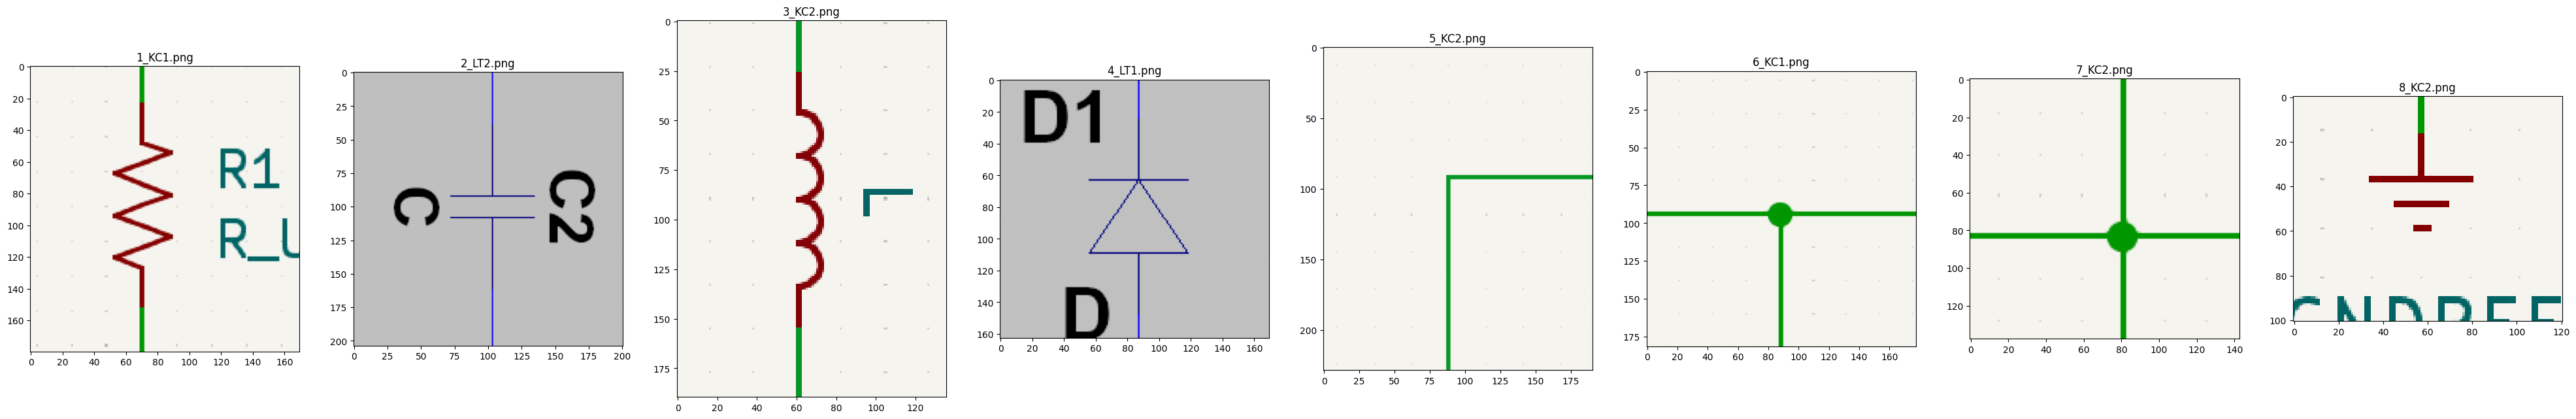

In [7]:
SPICENET_PARAMS["num_classes"] = len(SPICENET_PARAMS["class_list"])
fig, axs = plt.subplots(nrows=1, ncols=SPICENET_PARAMS["num_classes"] , figsize=(50, 50))

for i in range(SPICENET_PARAMS["num_classes"]):
    parts = [p for p in os.listdir(SPICENET_PARAMS["src_path"]) if p.startswith(f"{i+1}")]
    example_part = random.choice(parts)
    part_symbol = plt.imread(join(SPICENET_PARAMS["src_path"], example_part))
    axs[i].imshow(part_symbol)
    axs[i].title.set_text(f"{example_part}")

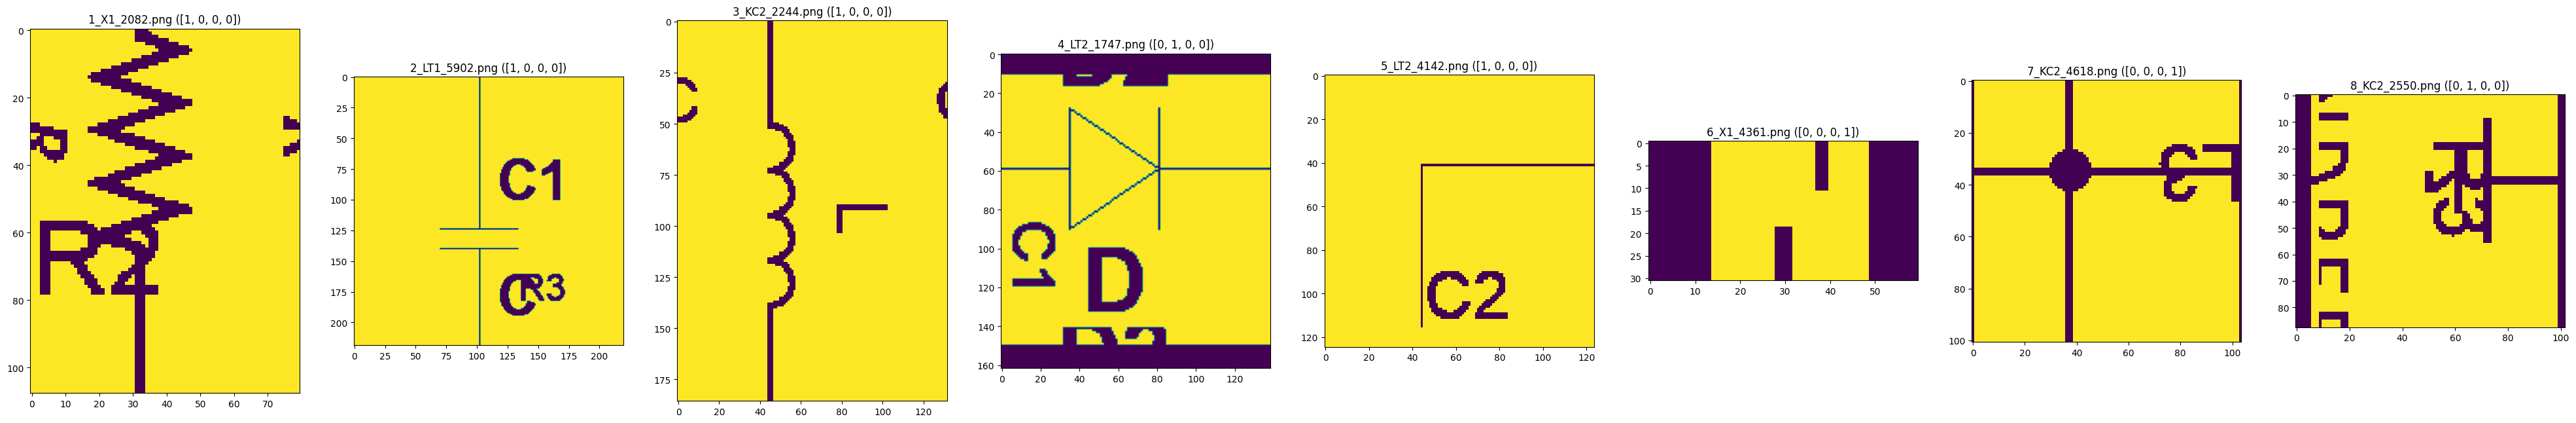

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=SPICENET_PARAMS["num_classes"] , figsize=(50, 50))
with open(join(SPICENET_PARAMS["dataset_path"], "rotations.json"), 'r') as json_file:
    rotations = json.load(json_file)

for i in range(SPICENET_PARAMS["num_classes"]):
    folder = join(SPICENET_PARAMS["dataset_path"], "train", f"{i+1}")
    example_part = random.choice(os.listdir(folder))
    part_symbol = plt.imread(join(folder, example_part))
    axs[i].imshow(part_symbol)
    one_hot = rotations[f"{example_part}"]
    axs[i].title.set_text(f"{example_part} ({one_hot})")


### Training
SPICEnet is actually **two** networks: one that classifies a component and one that detects orientation. Note that the orientation network may not perform well in terms of classification, because some parts (R, L, C) are symmetrical along one axis. In such a case, the predicted values can be added for the rotations 180° apart from each other. 

In [12]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = data_generator.flow_from_directory(
    directory=join(SPICENET_PARAMS["dataset_path"], "train"),
    target_size=(SPICENET_PARAMS["resize"], SPICENET_PARAMS["resize"]),
    batch_size=SPICENET_PARAMS["batches"],
    class_mode='categorical'
)

In [13]:
data_df = pd.DataFrame(list(rotations.items()), columns=['filename', 'rotation'])
data_df['rotation'] = data_df['rotation'].apply(lambda x: ' '.join(map(str, x[0])))

train_generator = data_generator.flow_from_dataframe(
    dataframe=data_df,
    directory=SPICENET_PARAMS["dataset_path"],
    x_col='filename',
    y_col='rotation',
    target_size=(SPICENET_PARAMS["resize"], SPICENET_PARAMS["resize"]),
    batch_size=SPICENET_PARAMS["batches"],
    class_mode='categorical',
    validate_filenames=False
)



Found 343894 images belonging to 8 classes.


In [14]:
test_generator = data_generator.flow_from_directory(
    directory=join(SPICENET_PARAMS["dataset_path"], "test"),
    target_size=(SPICENET_PARAMS["resize"], SPICENET_PARAMS["resize"]),
    batch_size=SPICENET_PARAMS["batches"],
    class_mode='categorical'
)

Found 241201 images belonging to 8 classes.


In [15]:
vgg16_model = VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
)
for layer in vgg16_model.layers:
    layer.trainable = False

classification = Dense(SPICENET_PARAMS["num_classes"], activation='softmax', name='classification')(vgg16_model.output)
rotation = Dense(len(SPICENET_PARAMS["rotation"]), activation='softmax', name='rotation')(vgg16_model.output)

spicenet = Model(inputs=vgg16_model.input, outputs=[classification, rotation])
spicenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

In [21]:
spicenet.compile(optimizer='adam', 
                 loss={'classification': 'categorical_crossentropy', 'rotation': 'categorical_crossentropy'}, 
                 metrics={'classification': 'accuracy', 'rotation': 'accuracy'})

In [22]:
steps_per_epoch_training = train_generator.n // SPICENET_PARAMS["batches"]
steps_per_epoch_test = test_generator.n // SPICENET_PARAMS["batches"]
print(steps_per_epoch_training)
print(steps_per_epoch_test)

17194
12060


In [18]:
%killbgscripts
%reload_ext tensorboard
log_dir = join(os.curdir, "logs", "fit", f"{datetime.now().strftime('%Y%m%d_%H%M%S')}") 
print(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%tensorboard --logdir .

All background processes were killed.
./logs/fit/20240121_190142


In [19]:
fit_history = spicenet.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=SPICENET_PARAMS["epochs"],
    validation_data=test_generator,
    validation_steps=steps_per_epoch_test,
    validation_batch_size=SPICENET_PARAMS["batches"],
    verbose=1,
    callbacks=[tensorboard_callback]
)
spicenet.save(f'SPICEnet.h5')

Epoch 1/2


2024-01-21 19:02:03.476975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2024-01-21 19:02:04.323052: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-21 19:02:05.899093: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1b294160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-21 19:02:05.899145: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-01-21 19:02:06.147893: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECT

    1/17194 [..............................] - ETA: 35:46:18 - loss: 7.9193 - classification_loss: 3.7044 - rotation_loss: 4.2149 - classification_accuracy: 0.4000 - rotation_accuracy: 0.2500

2024-01-21 19:02:07.855151: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


17194/17194 [==============================] - ETA: 0s - loss: 0.2313 - classification_loss: 0.0344 - rotation_loss: 0.1969 - classification_accuracy: 0.9910 - rotation_accuracy: 0.9271

2024-01-21 19:45:12.470534: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 70778880 exceeds 10% of free system memory.
2024-01-21 19:45:12.537953: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 141557760 exceeds 10% of free system memory.
2024-01-21 19:45:12.640702: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 141557760 exceeds 10% of free system memory.
2024-01-21 19:45:12.734961: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 283115520 exceeds 10% of free system memory.
2024-01-21 19:45:12.933335: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.


17194/17194 [==============================] - 2594s 150ms/step - loss: 0.2313 - classification_loss: 0.0344 - rotation_loss: 0.1969 - classification_accuracy: 0.9910 - rotation_accuracy: 0.9271 - val_loss: 0.1437 - val_classification_loss: 0.0044 - val_rotation_loss: 0.1393 - val_classification_accuracy: 0.9988 - val_rotation_accuracy: 0.9474
Epoch 2/2
17194/17194 [==============================] - 2510s 146ms/step - loss: 0.1307 - classification_loss: 0.0047 - rotation_loss: 0.1260 - classification_accuracy: 0.9985 - rotation_accuracy: 0.9526 - val_loss: 0.1340 - val_classification_loss: 0.0048 - val_rotation_loss: 0.1291 - val_classification_accuracy: 0.9984 - val_rotation_accuracy: 0.9518


In [20]:
def autopush_model(commit_msg):
    os.system('git add SPICEnet.h5')
    os.system(f'git commit -m "autopush SPICEnet: {commit_msg}"')
    os.system("git push origin")

autopush_model(datetime.now().strftime("%m/%d/%Y, %H:%M:%S"))

[dev 2b89c39] autopush SPICEnet: 01/21/2024, 20:27:16
 1 file changed, 0 insertions(+), 0 deletions(-)


remote: warning: See https://gh.io/lfs for more information.        
remote: warning: File SPICEnet.h5 is 56.29 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB        
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.        
To github.com:jake-is-ESD-protected/SPICEnet.git
   f78a056..2b89c39  dev -> dev


### Evaluation

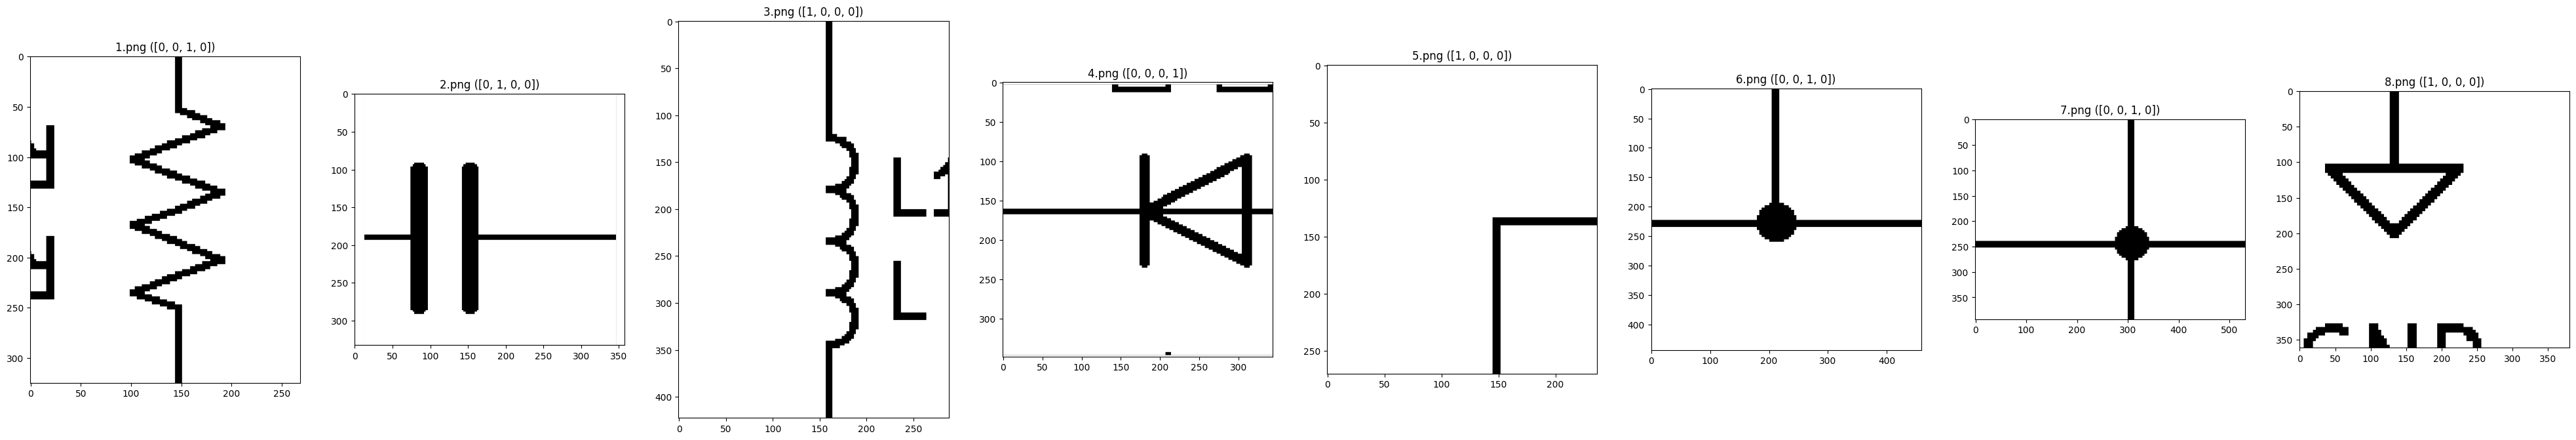

In [16]:
valid_folder = join(SPICENET_PARAMS["dataset_path"], "valid")

if os.access(valid_folder, os.F_OK) == True:
    shutil.rmtree(valid_folder)
os.mkdir(valid_folder)
shutil.copytree('./validation', valid_folder, dirs_exist_ok=True)

fig, axs = plt.subplots(nrows=1, ncols=SPICENET_PARAMS["num_classes"] , figsize=(50, 50))

valid_rotations = dict()
for i, part_path in enumerate(os.listdir(valid_folder)):
    img_path = join(valid_folder, part_path, f"{i+1}.png")
    image = Image.open(img_path)
    rotation = random.choice(list(SPICENET_PARAMS["rotation"]))
    image = data_rotate_image(image, rotation)
    image.save(img_path)
    one_hot = [0, 0, 0, 0]
    one_hot[rotation//90] = 1
    valid_rotations[f"{os.path.basename(img_path)}"] = one_hot
    part_symbol = plt.imread(img_path)
    axs[i].imshow(part_symbol)
    axs[i].title.set_text(f"{os.path.basename(img_path)} ({one_hot})")


In [17]:
evaluate_generator = CombinedDirectoryIterator(
    directory=valid_folder,
    image_data_generator=data_generator,
    one_hot_dict=valid_rotations,
    target_size=(SPICENET_PARAMS["resize"], SPICENET_PARAMS["resize"]),
    batch_size=SPICENET_PARAMS["batches"],
    class_mode='categorical'
)

Found 8 images belonging to 8 classes.


In [24]:
spicenet_evaluate_history = spicenet.evaluate(
    evaluate_generator,
    verbose=1,
)

1/1 [==============================] - 0s 163ms/step - loss: 20.1463 - classification_loss: 12.6360 - rotation_loss: 7.5104 - classification_accuracy: 0.1250 - rotation_accuracy: 0.1250


In [ ]:
print("SPICEnet component accuracy:", spicenet_evaluate_history[3])
print("SPICEnet rotation accuracy:", spicenet_evaluate_history[4])

SPICEnet component accuracy: 1.0
SPICEnet rotation accuracy: 0.5


2024-01-21 21:48:12.410393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2024-01-21 21:48:13.014097: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


1/1 [==============================] - 3s 3s/step
[[0, 0, 0, 0, 0, 0, 0, 99], [0, 0, 0, 0, 0, 1, 0, 97], [0, 0, 0, 0, 0, 0, 0, 99], [0, 0, 0, 0, 0, 0, 0, 99], [0, 0, 0, 0, 0, 0, 0, 99], [0, 0, 0, 0, 0, 0, 0, 99], [0, 0, 99, 0, 0, 0, 0, 0], [0, 92, 0, 0, 0, 6, 0, 0]]
[[31, 68, 0, 0], [99, 0, 0, 0], [0, 99, 0, 0], [51, 44, 0, 3], [52, 16, 31, 0], [44, 27, 28, 0], [22, 77, 0, 0], [95, 0, 0, 3]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


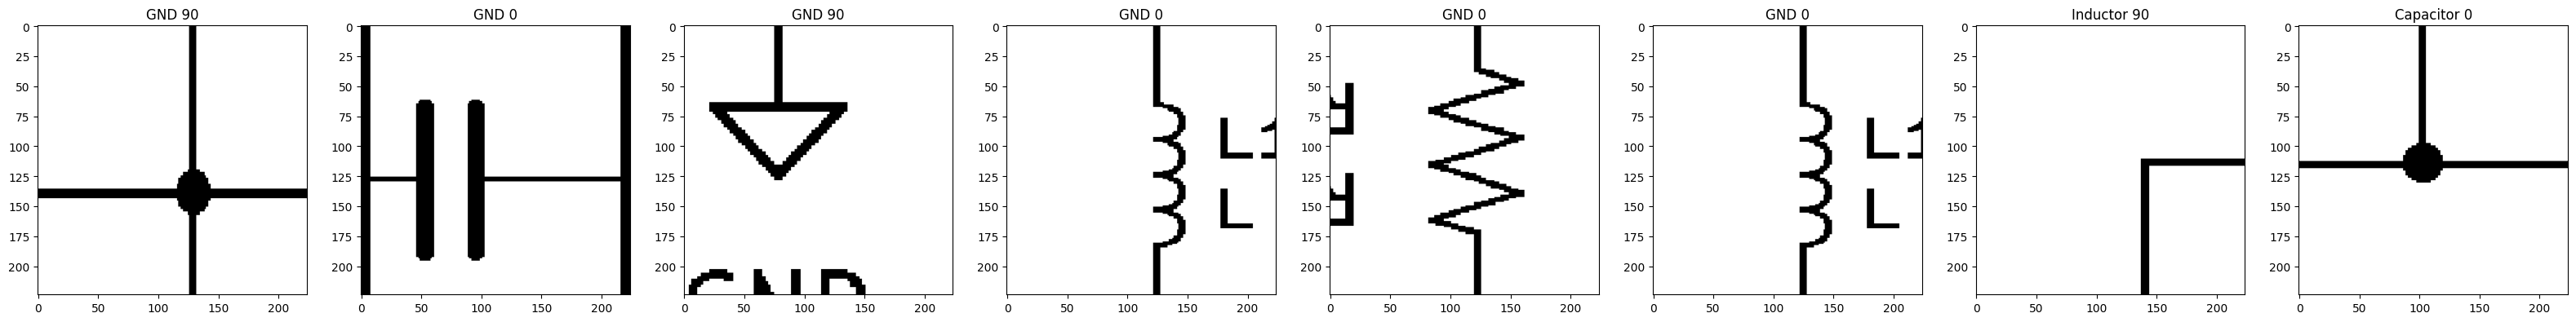

In [20]:
spicenet_predict = spicenet.predict(
    evaluate_generator
)
classifications = spicenet_predict[0] 
print([[int(y*100) for y in x] for x in classifications])
rotations = spicenet_predict[1]
print([[int(y*100) for y in x] for x in rotations])

classification_index = [SPICENET_PARAMS["class_list"][s] for s in np.argmax(classifications,axis=1)]
rotation_index = [list(SPICENET_PARAMS["rotation"])[s] for s in np.argmax(rotations,axis=1)]

# batch_images = evaluate_generator.next()[0]

fig, axs = plt.subplots(nrows=1, ncols=len(SPICENET_PARAMS["class_list"]), figsize=(40, 5))
ind = 0
for ax1 in axs:
    batch_images = evaluate_generator.next()[0]
    image_data = batch_images[ind]
    ax1.imshow(image_data, vmin=0, vmax=255)
    ax1.title.set_text(f"{classification_index[ind]} {rotation_index[ind]}")
    ind += 1

# fig.suptitle('Test Electronics Symbol Images') 
# plt.show()